In [2]:
#Import Packages
#Requires Python 3.10 or earlier
import py_wake
import numpy as np
import matplotlib.pyplot as plt

from py_wake import NOJ

<xarray.DataArray (sector: 12)> Size: 96B
array([0.05, 0.04, 0.04, 0.04, 0.06, 0.09, 0.16, 0.15, 0.07, 0.09, 0.13,
       0.08])
Coordinates:
  * sector   (sector) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
Attributes:
    description:  Probability of wind flow case (i.e. wind direction and wind...

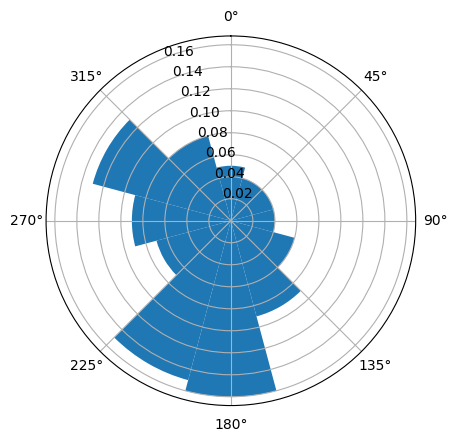

In [3]:
#Define Site
from py_wake.site import UniformWeibullSite
# Dummy offshore site object
wd = np.arange(0, 360, 30)
A = np.full_like(wd, 9.5, dtype=float) # Weibull scale parameter
k = np.full_like(wd, 2.0, dtype=float) # Weibull shape parameter


p_wd = np.array([0.05, 0.04, 0.04, 0.04, 0.06, 0.09, 0.16, 0.15, 0.07 ,0.09, 0.13, 0.08], dtype=float) # sector frequencies (defines wind direction)
p_wd /= p_wd.sum()

site = UniformWeibullSite(p_wd=p_wd, a=A, k=k, ti=0.08) # Create uniform weibull site
site.plot_wd_distribution(n_wd=12) # Plot wind rose

****Wind turbine specifications****

Power and Thrust coefficient (Ct) curves:


"\nwt = WindTurbine(name='MyWT',\n                    diameter=124,\n                    hub_height=320,\n                    powerCtFunction=PowerCtTabular(u,power,'kW',thrust_coeff))\n\nor \n\nwt = GenericWindTurbine('G10MW', 180, 120, power_norm=10000, turbulence_intensity=.1)\n\nSource: https://www.pythonpool.com/pywake-library/\n"

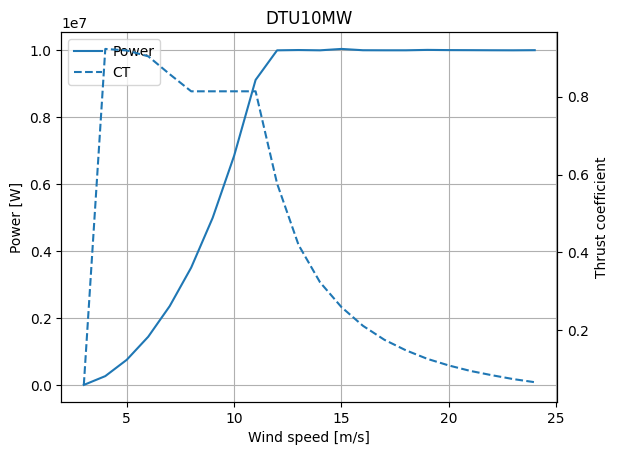

In [4]:
#Define Turbine
from py_wake.wind_turbines import WindTurbines
from py_wake.examples.data.dtu10mw import DTU10MW
from py_wake.wind_turbines import WindTurbine, WindTurbines
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
import numpy as np

diameter = 120 #Turbine blade diameter in m
hub_height = 100 #Hub height in m

wt = DTU10MW() #Example 10mw turbine https://backend.orbit.dtu.dk/ws/portalfiles/portal/55645274/The_DTU_10MW_Reference_Turbine_Christian_Bak.pdf

#Plot Data
print('****Wind turbine specifications****\n')
print("Power and Thrust coefficient (Ct) curves:")
ws = np.arange(3,25)
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Power [kW]')
wt.plot_power_ct(ws=ws)

'''
wt = WindTurbine(name='MyWT',
                    diameter=124,
                    hub_height=320,
                    powerCtFunction=PowerCtTabular(u,power,'kW',thrust_coeff))

or 

wt = GenericWindTurbine('G10MW', 180, 120, power_norm=10000, turbulence_intensity=.1)

Source: https://www.pythonpool.com/pywake-library/
'''

In [ ]:
#Define Turbine layout

# number of turbines in each direction:
n_x = 5
n_y = 4

rotor_diameter = diameter
dist_x = 10 * rotor_diameter
dist_y = 5 * rotor_diameter

# This defines the turbine positions
wt_x, wt_y = np.meshgrid(np.array(range(n_x)) * dist_x, np.array(range(n_y)) * dist_y)
wt_x = wt_x.flatten()
wt_y = wt_y.flatten()

x_max, x_min = wt_x.max(), wt_x.min()
y_max, y_min = wt_y.max(), wt_y.min()

n_wts = n_x * n_y


In [6]:
#Define Engineering windfarm model
from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014
windFarmModel = Bastankhah_PorteAgel_2014(site, wt, k=0.0324555)

Total AEP: 744.648423 GWh


Text(0.5, 1.0, 'AEP vs wind direction')

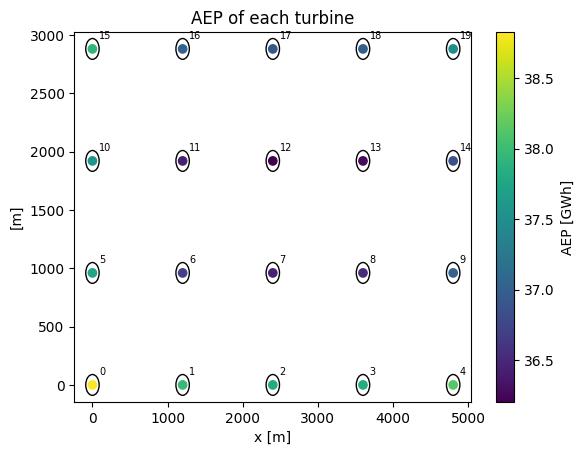

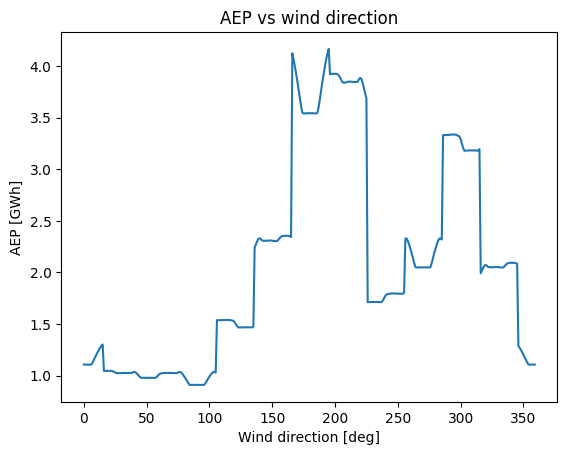

In [7]:
#Calculate AEP (Annual Energy Production)
from py_wake import NOJ

#import the wake deficit model
noj = NOJ(site,wt)
simulationResult = noj(wt_x,wt_y)

#Display Results
print ("Total AEP: %f GWh"%simulationResult.aep().sum())

plt.figure()
aep = simulationResult.aep() 
wt.plot(wt_x,wt_y)
c =plt.scatter(wt_x, wt_y, c=aep.sum(['wd','ws']))
plt.colorbar(c, label='AEP [GWh]')
plt.title('AEP of each turbine')
plt.xlabel('x [m]')
plt.ylabel('[m]')

plt.figure()
aep.sum(['wt','ws']).plot()
plt.xlabel("Wind direction [deg]")
plt.ylabel("AEP [GWh]")
plt.title('AEP vs wind direction')

Text(0.5, 1.0, 'Wake map for 10 m/s and 300 deg')

<Figure size 640x480 with 0 Axes>

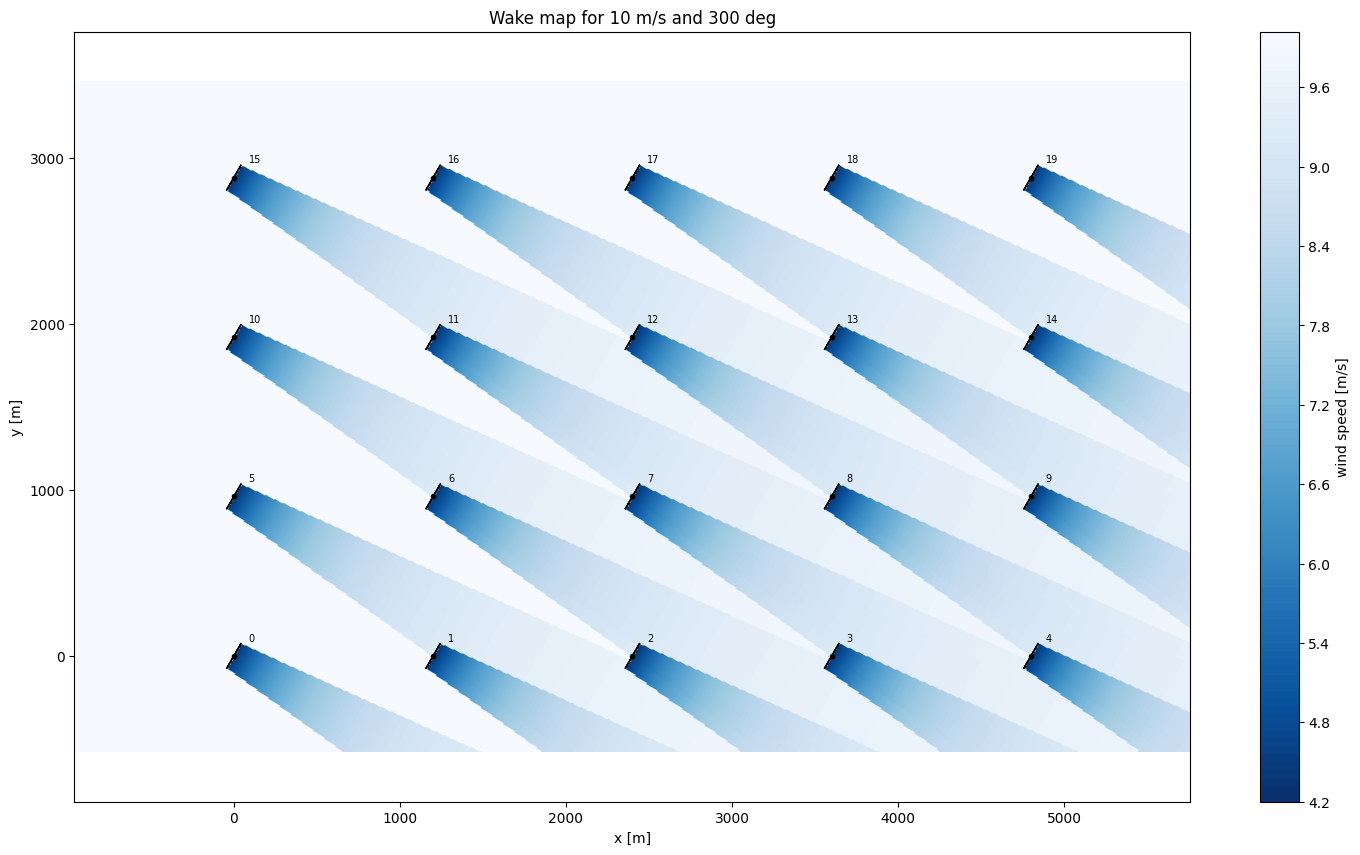

In [8]:
#Plot Flow Map
wind_speed = 10
wind_direction = 300

plt.figure()
flow_map = simulationResult.flow_map(ws=wind_speed, wd=wind_direction)
plt.figure(figsize=(18,10))
flow_map.plot_wake_map()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Wake map for' + f' {wind_speed} m/s and {wind_direction} deg')

Iteration limit reached    (Exit mode 9)
            Current function value: -752.189682546981
            Iterations: 50
            Function evaluations: 54
            Gradient evaluations: 50
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimized in	108.596s


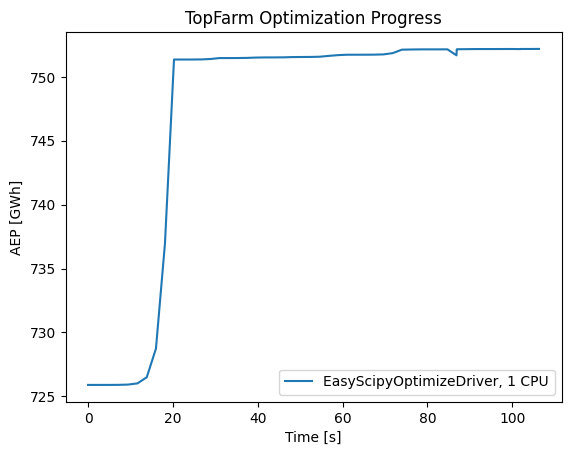

Iteration limit reached    (Exit mode 9)
            Current function value: -754.280338832761
            Iterations: 50
            Function evaluations: 52
            Gradient evaluations: 50
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimized in	106.729s


In [9]:
# --- TopFarm imports ---
from topfarm._topfarm import TopFarmProblem
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.easy_drivers import EasyScipyOptimizeDriver as fd

x_max, x_min = wt_x.max(), wt_x.min()
y_max, y_min = wt_y.max(), wt_y.min()

boundary = [
    (-1000,-1000),
    (-1000,y_max+1000),
    (x_max+1000,y_max+1000),
    (x_max+1000,-1000)
]

#boundary = [ (0, 0), (5000, 0), (5000, 4000), (2000, 6000), (0, 4000) ]

x0, y0 = np.meshgrid(np.array(range(n_x)) * dist_x, np.array(range(n_y)) * dist_y)
x0 = x0.flatten() 
y0 = y0.flatten()
def get_topfarmProblem_xy(wfm, x, y, grad_method, maxiter, n_cpu):
    
    farm_boundary = np.array(boundary)
    boundary_constr = XYBoundaryConstraint( 
        farm_boundary,
        boundary_type='polygon' 
    )

    return TopFarmProblem(
        design_vars={'x': x, 'y': y},
        cost_comp=PyWakeAEPCostModelComponent(
            windFarmModel=wfm,
            n_wt=len(x),
            grad_method=None,
            wd=wfm.site.default_wd,
            ws=wfm.site.default_ws
        ),
        driver=fd(maxiter=maxiter),
        constraints=[
            boundary_constr,
            SpacingConstraint(min_spacing=2 * wfm.windTurbines.diameter())
        ]
    )


def optimize_and_plot(wfm, x0, y0, maxiter):
    method = fd
    n_cpu = 1

    tf = get_topfarmProblem_xy(wfm, x0, y0, method, maxiter, n_cpu)
    cost, state, recorder = tf.optimize(disp=True)

    t, aep = [recorder[v] for v in ['timestamp', 'AEP']]
    plt.plot(t - t[0], aep, label=f'{method.__name__}, {n_cpu} CPU')

    plt.xlabel("Time [s]")
    plt.ylabel("AEP [GWh]")
    plt.title("TopFarm Optimization Progress")
    plt.legend()
    plt.show()
    return tf, cost, state, recorder


# --- Run optimization ---
tf, cost, state, recorder = optimize_and_plot(windFarmModel, x0, y0, maxiter=50)
cost, state, recorder = tf.optimize(disp=True)


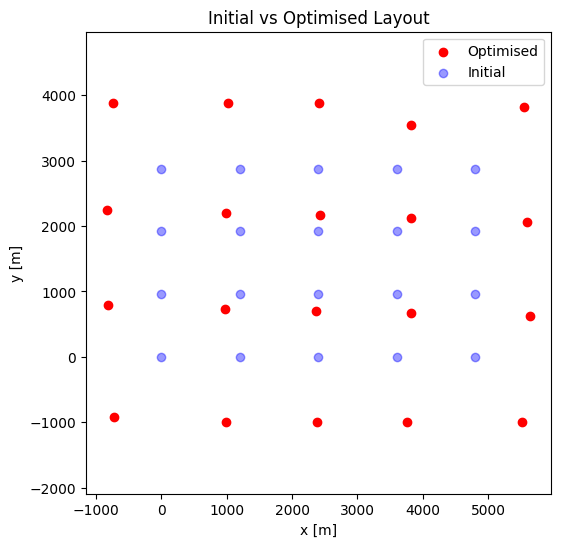

Total AEP: 765.732985 GWh


Text(0.5, 1.0, 'Wake map for new layout with 10 m/s and 300 deg')

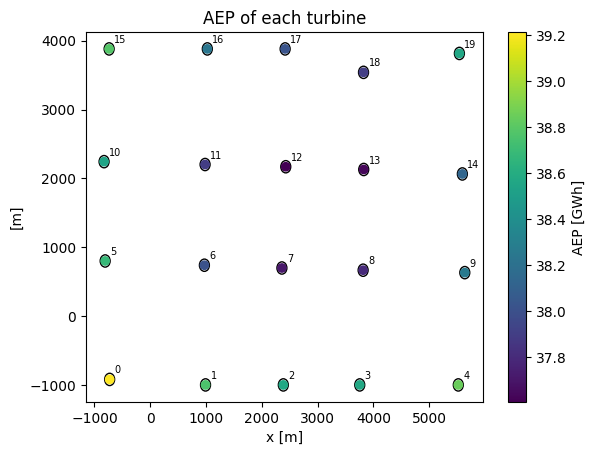

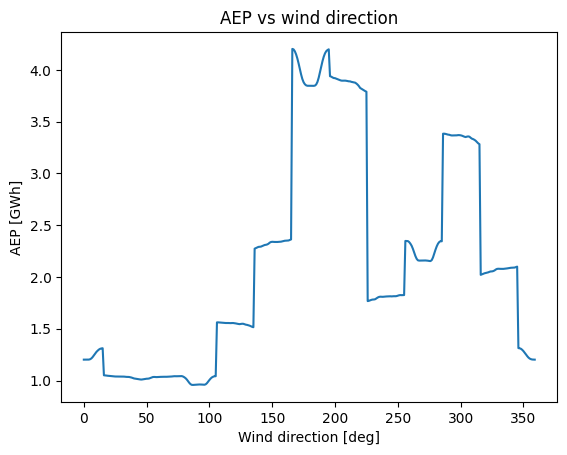

<Figure size 640x480 with 0 Axes>

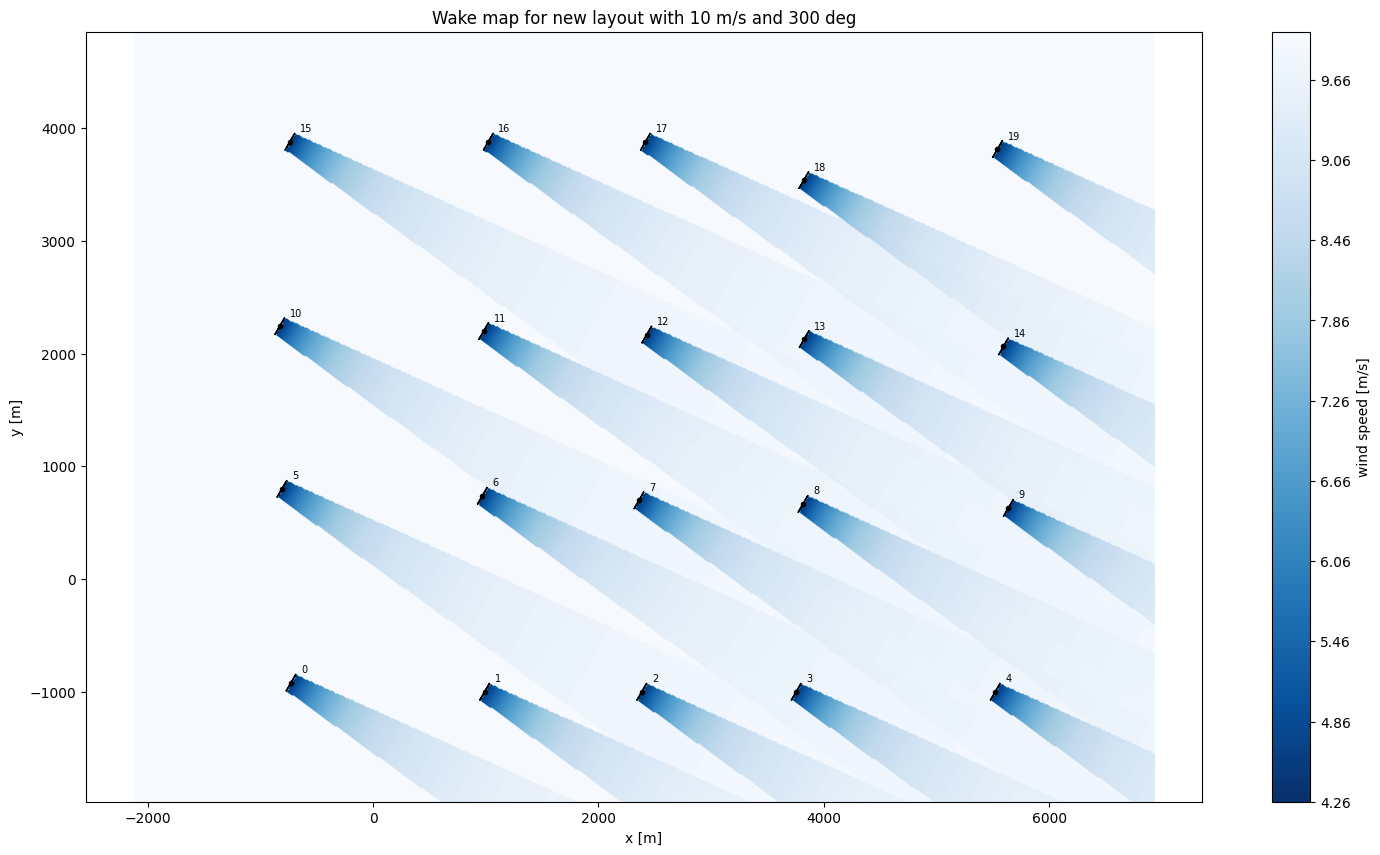

In [10]:
# Plot results
plt.figure(figsize=(6,6))
plt.scatter(state['x'], state['y'], c='red', label='Optimised')
plt.scatter(x0, y0, c='blue', alpha=0.4, label='Initial')
plt.legend()
plt.title("Initial vs Optimised Layout")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.axis("equal")
plt.show()

#Define Engineering windfarm model for new layout
from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014
windFarmModelNew = Bastankhah_PorteAgel_2014(site, wt, k=0.0324555)

#import the wake deficit model
noj = NOJ(site,wt)
newSimulationResult = noj(x=state['x'],y=state['y'])

#Simulate AEP
newSimulationResult.aep()

#Display Results for new simulation
print ("Total AEP: %f GWh"%newSimulationResult.aep().sum())

plt.figure()
aep = newSimulationResult.aep() 
wt.plot(x=state['x'],y=state['y'])
c =plt.scatter(x=state['x'],y=state['y'], c=aep.sum(['wd','ws']))
plt.colorbar(c, label='AEP [GWh]')
plt.title('AEP of each turbine')
plt.xlabel('x [m]')
plt.ylabel('[m]')

plt.figure()
aep.sum(['wt','ws']).plot()
plt.xlabel("Wind direction [deg]")
plt.ylabel("AEP [GWh]")
plt.title('AEP vs wind direction')

#Plot Flow Map for new layout

plt.figure()
flow_map_new = newSimulationResult.flow_map(ws=wind_speed, wd=wind_direction)
plt.figure(figsize=(18,10))
flow_map_new.plot_wake_map()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Wake map for new layout with' + f' {wind_speed} m/s and {wind_direction} deg')